<a href="https://colab.research.google.com/github/danahalghamdi/week4-SDAIA/blob/main/vehicle_image_classification_cnn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project applies fine-tuning for image classification using a pretrained deep learning model.
The dataset used is CIFAR-10, from which vehicle-related classes were selected: airplane, automobile, ship, and truck.
The images are labeled accordingly and used to adapt a pretrained model to a new classification task.

A pretrained ResNet18 model, originally trained on the ImageNet dataset, was used in this project.
The pretrained convolutional layers were frozen, and only the final fully connected layer was retrained to classify the selected vehicle categories.
This approach allows the model to leverage learned visual features while efficiently adapting to the target dataset.

The fine-tuned model was evaluated on unseen data to assess its generalization performance.

# Dataset: CIFAR-10  (airplane, automobile, ship, truck)
# Model: Fine-tuned Model

— Imports



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import numpy as np

##— Device Setup


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


##  — Data Preparation (CIFAR-10 Vehicle Classes)

We load CIFAR-10 and keep only vehicle-related classes:
airplane, automobile, ship, and truck.

Since ResNet18 was pretrained on ImageNet, we resize images to 224x224
and apply ImageNet normalization.

In [3]:
# CIFAR-10 class IDs:
# airplane=0, automobile=1, ship=8, truck=9
keep_cifar_ids = [0, 1, 8, 9]
new_label_map = {0: 0, 1: 1, 8: 2, 9: 3}  # remap to [0..3]
class_names = ["airplane", "automobile", "ship", "truck"]

# ImageNet normalization values (required for pretrained ResNet models)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

train_full = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
test_full  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

# Filter only vehicle classes
train_indices = [i for i, y in enumerate(train_full.targets) if y in keep_cifar_ids]
test_indices  = [i for i, y in enumerate(test_full.targets) if y in keep_cifar_ids]

train_ds = Subset(train_full, train_indices)
test_ds  = Subset(test_full, test_indices)

print("Train subset size:", len(train_ds))
print("Test subset size:", len(test_ds))

100%|██████████| 170M/170M [00:19<00:00, 8.55MB/s]


Train subset size: 20000
Test subset size: 4000


##  — Label Remapping



In [4]:
class RemapLabelsDataset(torch.utils.data.Dataset):
    def __init__(self, subset, base_dataset, label_map):
        self.subset = subset
        self.base_dataset = base_dataset
        self.label_map = label_map

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return x, self.label_map[y]

train_ds = RemapLabelsDataset(train_ds, train_full, new_label_map)
test_ds  = RemapLabelsDataset(test_ds, test_full, new_label_map)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

In [5]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = correct / total * 100
        print(f"Epoch [{epoch+1}/{num_epochs}] - Test Acc: {acc:.2f}%")

    return model

##  — Load a Pretrained ResNet18 Model


In [6]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# 1. Use a pretrained model and replace the classification head
model.fc = nn.Linear(model.fc.in_features, 4)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s]


In [7]:
from torch.utils.data import Subset
import numpy as np

# نسبة الداتا الصغيرة )
small_frac = 0.2   # 20%

# اختاري عيّنة عشوائية من train_ds
n_small = int(len(train_ds) * small_frac)
idx = np.random.permutation(len(train_ds))[:n_small]

train_ds_small = Subset(train_ds, idx)

# داتا لودر للداتا الصغيرة
train_loader_small = DataLoader(
    train_ds_small,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

print("Full train size:", len(train_ds))
print("Small train size:", len(train_ds_small))

Full train size: 20000
Small train size: 4000


##  — Freezing the Pretrained Layers (Freeze)



In [8]:
#2. Freeze and train only the new layer
for name, param in model.named_parameters():
    param.requires_grad = False


for param in model.fc.parameters():
    param.requires_grad = True

## Step  — Training Setup



In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

##   — Training the Fine-Tuned Model


In [10]:
def evaluate_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

num_epochs = 3 # start small you can increase to 5 later

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    test_acc = evaluate_accuracy(model, test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f} - Test Acc: {test_acc*100:.2f}%")

Epoch [1/3] - Loss: 0.5837 - Test Acc: 85.08%
Epoch [2/3] - Loss: 0.3908 - Test Acc: 86.38%
Epoch [3/3] - Loss: 0.3614 - Test Acc: 86.48%


##  - Confusion Matrix Evaluation


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return cm

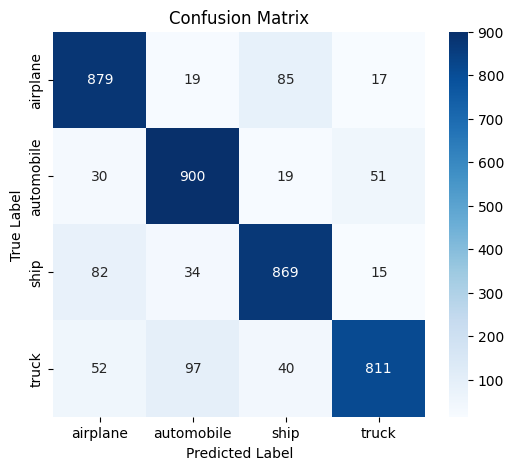

In [12]:
cm_finetuned = plot_confusion_matrix(model, test_loader, class_names)

#  — Unfreeze and Retrain the Entire Model

In [13]:
# 3. Load a fresh pretrained model for unfreeze experiment
weights = ResNet18_Weights.DEFAULT
model_unfreeze = resnet18(weights=weights)

# Replace final layer
model_unfreeze.fc = nn.Linear(model_unfreeze.fc.in_features, 4)
model_unfreeze = model_unfreeze.to(device)

# Unfreeze all layers
for param in model_unfreeze.parameters():
    param.requires_grad = True

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer_unfreeze = optim.Adam(model_unfreeze.parameters(), lr=1e-4)

In [15]:
model_unfreeze = train_model(
    model_unfreeze,
    train_loader,
    test_loader,
    criterion,
    optimizer_unfreeze,
    num_epochs=3,
    device=device
)

Epoch [1/3] - Test Acc: 95.90%
Epoch [2/3] - Test Acc: 96.95%
Epoch [3/3] - Test Acc: 96.45%


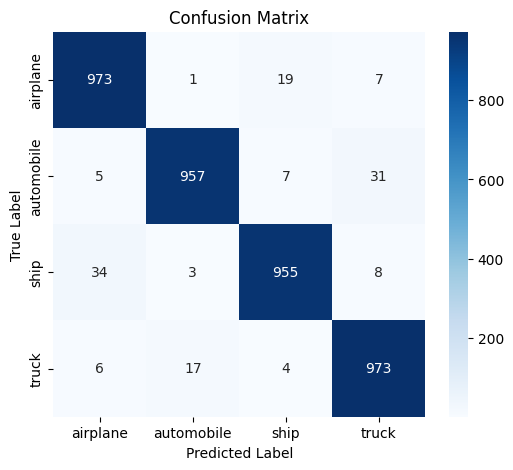

In [16]:
cm_unfreeze = plot_confusion_matrix(model_unfreeze, test_loader, class_names)

# Freeze: faster training, lower accuracy
# Unfreeze: slower training, higher accuracy

 ## Small Dataset

In [17]:
trained_freeze_small = train_model(
    model,
    train_loader_small,
    test_loader,
    criterion,
    optimizer,
    num_epochs=3,
    device=device
)

Epoch [1/3] - Test Acc: 87.05%
Epoch [2/3] - Test Acc: 85.95%
Epoch [3/3] - Test Acc: 86.17%


In [18]:
trained_unfreeze_small = train_model(
    model_unfreeze,
    train_loader_small,
    test_loader,
    criterion,
    optimizer_unfreeze,
    num_epochs=3,
    device=device
)

Epoch [1/3] - Test Acc: 96.75%
Epoch [2/3] - Test Acc: 97.00%
Epoch [3/3] - Test Acc: 97.02%


#Difference Between Freeze and Unfreeze

The Freeze technique keeps the pretrained layers fixed and updates only the final classification layer. This approach results in faster training and reduces the risk of overfitting, but it limits the model’s ability to adapt to the new task, which often leads to lower accuracy.

In contrast, Unfreeze allows all layers of the model to be retrained. This enables the network to adjust its learned features to better match the target dataset, resulting in higher accuracy, but with increased training time.

#Why Unfreeze Outperformed Freeze on Both Small and Large Datasets

In this experiment, the Unfreeze approach achieved higher accuracy for both small and large datasets. This is because the selected vehicle classes are visually similar to those in the ImageNet dataset on which the model was originally trained. Additionally, the number of target classes is small and the number of training epochs is limited, which helped reduce overfitting. As a result, retraining the entire model improved performance without negatively affecting generalization.

رغم أن الـ Unfreeze قد يسبب
overfitting مع الداتا الصغيرة،
إلا أن في هذه التجربة أعطى دقة أعلى لأن الداتا قريبة من
ImageNet،
وعدد
 الكلاسات قليل، وعدد الـ
 epochs
 محدود

## Step  — Inference on an External Image

We test the fine-tuned model on an external image uploaded manually.
This demonstrates model inference on unseen data.


In [19]:
from google.colab import files
from PIL import Image
import PIL.ImageOps as ops

uploaded = files.upload()
fname = list(uploaded.keys())[0]

img = Image.open(fname).convert("RGB")

# Use the same preprocessing as test (resize + normalize for ResNet)
x = test_transform(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    logits = model(x)
    pred = logits.argmax(dim=1).item()

print("Predicted class:", class_names[pred])

Saving images.jpeg to images.jpeg
Predicted class: automobile


---------------------------

#Conclusion

This project demonstrated the effectiveness of transfer learning using a pretrained ResNet18 model for vehicle image classification. By comparing Freeze and Unfreeze strategies on both small and large datasets, it was observed that freezing the pretrained layers provided faster training but limited accuracy, while unfreezing the entire model consistently achieved higher accuracy at the cost of longer training time.

The results show that unfreezing the model allows better feature adaptation when the dataset is visually similar to ImageNet and the number of classes is small. Overall, the experiments highlight the trade-off between training efficiency and performance, and emphasize the importance of selecting an appropriate fine-tuning strategy based on dataset size and task requirements.